## 1. Loading necessary libraries

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [195]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

# import nbimporter
# import src.modelling_pipeline as modelling
# #reload(modelling)

In [4]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [7]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


In [8]:
columns = ["SUBJECT_ID", "HADM_ID"]
num_unique_combinations = df_demographic.drop_duplicates(subset=columns).shape[0]

print("Number of unique combinations (>18 years old):")
print(num_unique_combinations)

Number of unique combinations (>18 years old):
50766


## 3. Dataset Extraction

In [88]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [10, 20, 30, 40]

In [50]:
dfs_dict = {}
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/full_data/t{hour}_top{top_n}.csv'
    dfs_dict[f'top{top_n}'][f't{hour}']=dataLoader.extract_full_data_by_features(df_labevents, df_demographic, df_desc_labitems, hour, feature_filename, top_n, output_filename)


In [58]:
dfs_dict['top10']['t0']

,SUBJECT_ID,HADM_ID,AGE,IS_SEPSIS,GENDER_NUM,ITEMID_50885,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51279,ITEMID_51301,SOFA
0,22,165315,64,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999
1,23,152223,71,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999
2,23,124321,75,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999
3,24,161859,39,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999
4,25,129635,58,0,0,-999.0,1.6,378.0,50.0,37.9,13.1,9.5,84.6,269.0,12.8,4.17,12.2,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50713,98794,190603,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999
50714,98797,105447,88,1,0,-999.0,0.7,-999.0,15.0,29.5,9.3,-999.0,-999.0,184.0,24.1,3.41,6.2,-999
50715,98800,191113,19,0,1,-999.0,0.6,-999.0,9.0,43.8,13.9,-999.0,-999.0,241.0,10.8,4.61,8.9,-999
50716,98802,101071,83,0,1,-999.0,1.3,-999.0,20.0,42.2,14.8,-999.0,-999.0,271.0,11.8,5.03,30.3,-999


## 4. Data processing

### 4.1 Missing values

In [175]:
mp.count_missing_values(dfs_dict['top10'])

Number of missing values in t0: 337938 (39.19%)
Number of missing values in t1: 281873 (32.70%)
Number of missing values in t2: 252276 (29.27%)
Number of missing values in t3: 229446 (26.63%)
Number of missing values in t4: 209346 (24.31%)
Number of missing values in t5: 191785 (22.28%)
Number of missing values in t6: 177380 (20.63%)
Number of missing values in t7: 165824 (19.31%)
Number of missing values in t8: 156133 (18.21%)


In [176]:
mp.count_missing_values(dfs_dict['top20'])

Number of missing values in t0: 655171 (49.68%)
Number of missing values in t1: 552885 (41.93%)
Number of missing values in t2: 501521 (38.05%)
Number of missing values in t3: 461332 (35.01%)
Number of missing values in t4: 425678 (32.32%)
Number of missing values in t5: 393840 (29.92%)
Number of missing values in t6: 366778 (27.89%)
Number of missing values in t7: 344198 (26.21%)
Number of missing values in t8: 325172 (24.80%)


In [177]:
mp.count_missing_values(dfs_dict['top30'])

Number of missing values in t0: 1022882 (56.02%)
Number of missing values in t1: 881229 (48.27%)
Number of missing values in t2: 808140 (44.28%)
Number of missing values in t3: 751050 (41.17%)
Number of missing values in t4: 701282 (38.46%)
Number of missing values in t5: 657403 (36.07%)
Number of missing values in t6: 620056 (34.05%)
Number of missing values in t7: 588585 (32.37%)
Number of missing values in t8: 561948 (30.95%)


In [162]:
mp.count_missing_values(dfs_dict['top40'])

Number of missing values in t0: 1368814 (59.97%)
Number of missing values in t1: 1194105 (52.33%)
Number of missing values in t2: 1104934 (48.43%)
Number of missing values in t3: 1035111 (45.39%)
Number of missing values in t4: 974102 (42.74%)
Number of missing values in t5: 920375 (40.40%)
Number of missing values in t6: 874361 (38.42%)
Number of missing values in t7: 835039 (36.74%)
Number of missing values in t8: 801458 (35.32%)


In [178]:
mp.count_missing_values(dfs_dict['top50'])

Number of missing values in t0: 1807579 (64.80%)
Number of missing values in t1: 1604770 (57.54%)
Number of missing values in t2: 1504609 (53.96%)
Number of missing values in t3: 1426413 (51.17%)
Number of missing values in t4: 1358766 (48.78%)
Number of missing values in t5: 1299374 (46.67%)
Number of missing values in t6: 1248370 (44.88%)
Number of missing values in t7: 1204685 (43.37%)
Number of missing values in t8: 1167227 (42.08%)


In [164]:
mp.count_missing_SOFA(dfs_dict['top20'])

Number of missing SOFA in t0: 39568 (78.02%)
Number of missing SOFA in t1: 36742 (72.45%)
Number of missing SOFA in t2: 35110 (69.25%)
Number of missing SOFA in t3: 33783 (66.66%)
Number of missing SOFA in t4: 32728 (64.62%)
Number of missing SOFA in t5: 31871 (62.96%)
Number of missing SOFA in t6: 31045 (61.38%)
Number of missing SOFA in t7: 30262 (59.92%)
Number of missing SOFA in t8: 29525 (58.55%)


In [165]:
mp.count_missing_SOFA(dfs_dict['top30'])

Number of missing SOFA in t0: 39568 (78.02%)
Number of missing SOFA in t1: 36742 (72.45%)
Number of missing SOFA in t2: 35110 (69.25%)
Number of missing SOFA in t3: 33783 (66.66%)
Number of missing SOFA in t4: 32728 (64.62%)
Number of missing SOFA in t5: 31871 (62.96%)
Number of missing SOFA in t6: 31045 (61.38%)
Number of missing SOFA in t7: 30262 (59.92%)
Number of missing SOFA in t8: 29525 (58.55%)


In [54]:
dfs_dict.keys()

dict_keys(['top10', 'top20', 'top30', 'top40', 'top50'])

In [55]:
dfs_dict[key].keys()

dict_keys(['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8'])

In [69]:
# Remove admissions with >5% missing values

def filter_missing_rows(df):
    # Count the number of -999 values in each row
    count_minus999 = (df == -999).sum(axis=1)

    # Calculate the percentage of -999 values for each row
    percent_minus999 = count_minus999 / df.shape[1] * 100

    # Return a dataframe with rows having 50% or less -999 values
    return df[percent_minus999 <= 50]

In [134]:
# Iterate through all dataframes in dfs_dict and update them
dfs_dict_without_missing = {}
for key in dfs_dict.keys():
    dfs_dict_without_missing[key] = {}
    for subkey in dfs_dict[key].keys():
        dfs_dict_without_missing[key][subkey] = filter_missing_rows(dfs_dict[key][subkey])
        dfs_dict_without_missing[key][subkey]= dfs_dict_without_missing[key][subkey].drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

In [135]:
dfs_dict_without_missing['top40']['t3']

,AGE,IS_SEPSIS,GENDER_NUM,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,ITEMID_50861,...,ITEMID_51250,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,SOFA
0,64,0,1,22.0,-999.0,-999.0,29.0,7.47,287.0,19.0,...,90.0,62.2,259.0,12.4,30.1,12.6,4.00,5.1,0.0,2
4,58,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,91.0,84.6,269.0,12.8,34.6,13.0,4.17,12.2,-999.0,-999
8,72,0,0,27.0,-999.0,1.4,36.0,7.47,148.0,32.0,...,102.0,-999.0,109.0,13.2,29.4,14.7,2.94,6.9,12.0,3
10,82,0,0,-999.0,-999.0,3.0,-999.0,-999.00,-999.0,18.0,...,90.0,81.0,503.0,13.3,26.4,13.2,4.08,28.3,-999.0,0
11,65,0,0,23.0,-999.0,-999.0,33.0,7.43,53.0,-999.0,...,89.0,-999.0,299.0,12.3,25.0,13.5,4.55,11.1,-999.0,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50672,80,1,1,16.0,119.0,2.9,41.0,7.17,256.0,19.0,...,101.0,88.5,164.0,11.8,51.5,13.3,2.85,13.3,-999.0,4
50673,53,0,0,-999.0,-999.0,3.3,-999.0,-999.00,-999.0,-999.0,...,87.0,73.0,195.0,15.9,29.1,13.9,4.58,25.4,-999.0,-999
50675,88,1,0,33.0,163.0,2.6,61.0,7.32,193.0,-999.0,...,87.0,-999.0,184.0,24.1,33.6,15.8,3.41,6.2,-999.0,-999
50676,19,0,1,25.0,99.0,-999.0,53.0,7.27,433.0,-999.0,...,93.0,89.4,151.0,14.3,28.7,12.7,3.15,15.1,-999.0,-999


In [136]:
(dfs_dict_without_missing['top40']['t3']['ITEMID_50809'] == -999).sum(axis=0)

30348

### 4.3 Train/Test Split & Standardisation

In [137]:
top = 'top40' # top40 is selected with the greatest overlap between Kha and Nyam
X_t0_train, X_t0_test, y_t0_train, y_t0_test = mp.split_data(dfs_dict_without_missing[top]['t0'])
X_t1_train, X_t1_test, y_t1_train, y_t1_test = mp.split_data(dfs_dict_without_missing[top]['t1'])
X_t2_train, X_t2_test, y_t2_train, y_t2_test = mp.split_data(dfs_dict_without_missing[top]['t2'])
X_t3_train, X_t3_test, y_t3_train, y_t3_test = mp.split_data(dfs_dict_without_missing[top]['t3'])
X_t4_train, X_t4_test, y_t4_train, y_t4_test = mp.split_data(dfs_dict_without_missing[top]['t4'])

### 4.4 Class weights

In [138]:
# Obtaining the class weights for model fitting
class_weights = mp.get_class_weights(y_t0_train)
class_weights

{0: 1.147, 1: 7.8014}

## 5. Model Fitting

In [139]:
# Initialise candidate models
candidate_models = {
    'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=class_weights, C=0.1, penalty=None, random_state=901),
    'Random_Forest': RandomForestClassifier(class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250, random_state=901),
    'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
    
    
    # 'SGD_Classifier': SGDClassifier(class_weight=class_weights),
    # 'XGB': XGBClassifier(),
    # 'KNeighbors': KNeighborsClassifier(),
    # 'Adaboost':AdaBoostClassifier()
    }

In [140]:
performance_df_t0 = mp.static_models(candidate_models, class_weights, X_t0_train, y_t0_train, X_t0_test, y_t0_test, time = 't0')
performance_df_t1 = mp.static_models(candidate_models, class_weights, X_t1_train, y_t1_train, X_t1_test, y_t1_test, time = 't1')
performance_df_t2 = mp.static_models(candidate_models, class_weights, X_t2_train, y_t2_train, X_t2_test, y_t2_test, time = 't2')
performance_df_t3 = mp.static_models(candidate_models, class_weights, X_t3_train, y_t3_train, X_t3_test, y_t3_test, time = 't3')
performance_df_t4 = mp.static_models(candidate_models, class_weights, X_t4_train, y_t4_train, X_t4_test, y_t4_test, time = 't4')

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries bef

# 6. Model Evaluation

In [141]:
performance_df = pd.concat([performance_df_t0, performance_df_t1, performance_df_t2, performance_df_t3, performance_df_t4])
performance_df = performance_df.sort_values(by='Model')
performance_df.reset_index(drop=True, inplace=True)
performance_df

,Model,Balanced_Acc_Train,Balanced_Acc_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,Gradient_Boosting_t0,0.598934,0.571097,0.723822,0.601156,0.209629,0.157576,0.325103,0.249700
1,Gradient_Boosting_t1,0.630208,0.610653,0.726758,0.635484,0.275682,0.241718,0.399733,0.350222
2,Gradient_Boosting_t2,0.628709,0.614464,0.701166,0.612188,0.274309,0.251995,0.394343,0.357027
3,Gradient_Boosting_t3,0.620331,0.594883,0.704204,0.614148,0.255865,0.208288,0.375350,0.311075
4,Gradient_Boosting_t4,0.619740,0.583410,0.710468,0.602787,0.253712,0.183457,0.373901,0.281301
5,Logistic_Regression_t0,0.684072,0.676893,0.244966,0.242035,0.673237,0.656061,0.359223,0.353614
6,Logistic_Regression_t1,0.727395,0.731556,0.283132,0.284696,0.725238,0.734969,0.407267,0.410415
7,Logistic_Regression_t2,0.731847,0.741107,0.284964,0.288538,0.727402,0.749145,0.409503,0.416614
8,Logistic_Regression_t3,0.733439,0.719952,0.284445,0.274744,0.724768,0.702290,0.408549,0.394971
9,Logistic_Regression_t4,0.735197,0.741345,0.282780,0.288526,0.722694,0.730647,0.406502,0.413690


In [182]:
hours = [0, 1, 2, 3, 4]
top_n_features = [10, 20, 30, 40]

In [196]:
cv_overall_df = mp.cv_analysis_all(X_t0_train, y_t0_train, 
                                   X_t1_train, y_t1_train,
                                   X_t2_train, y_t2_train,
                                   X_t3_train, y_t3_train,
                                   X_t4_train, y_t4_train,
                                   candidate_models, hours, top_n_features)

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

In [197]:
cv_overall_df

,model,t0,t1,t2,t3,t4,overall_avg_balanced_acc
0,Logistic_Regression_10,0.679874,NaN,NaN,NaN,NaN,0.679874
1,Random_Forest_10,0.727200,NaN,NaN,NaN,NaN,0.727200
2,Gradient_Boosting_10,0.570694,NaN,NaN,NaN,NaN,0.570694
3,Logistic_Regression_20,0.679874,NaN,NaN,NaN,NaN,0.679874
4,Random_Forest_20,0.727200,NaN,NaN,NaN,NaN,0.727200
5,Gradient_Boosting_20,0.570694,NaN,NaN,NaN,NaN,0.570694
6,Logistic_Regression_30,0.679874,NaN,NaN,NaN,NaN,0.679874
7,Random_Forest_30,0.727200,NaN,NaN,NaN,NaN,0.727200
8,Gradient_Boosting_30,0.570694,NaN,NaN,NaN,NaN,0.570694
9,Logistic_Regression_40,0.679874,NaN,NaN,NaN,NaN,0.679874


In [198]:
# Convert the table to LaTeX format to import to Overleaf
cv_overall_latex_table = cv_overall_df.to_latex(index=False, escape=False, caption="Traditional Machine Learning models comparison at different time snaps and top features")

print(cv_overall_latex_table)

\begin{table}
\caption{Traditional Machine Learning models comparison at different time snaps and top features}
\begin{tabular}{lrrrrrr}
\toprule
model & t0 & t1 & t2 & t3 & t4 & overall_avg_balanced_acc \\
\midrule
Logistic_Regression_10 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_10 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_10 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_20 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_20 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_20 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_30 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_30 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_30 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_40 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_40 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_40 &

In [177]:
# 5-fold Cross Validation
cv_df_t0 = mp.cv_analysis(X_t0_train, y_t0_train, candidate_models, 't0')
cv_df_t0

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,model,average_balanced_acc
0,Gradient_Boosting_t0,0.679874
1,Gradient_Boosting_t0,0.727200
2,Gradient_Boosting_t0,0.570694


In [178]:
# 5-fold Cross Validation
cv_df_t1 = mp.cv_analysis(X_t1_train, y_t1_train, candidate_models, "t1")
cv_df_t1

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,model,average_balanced_acc
0,Gradient_Boosting_t1,0.724838
1,Gradient_Boosting_t1,0.751944
2,Gradient_Boosting_t1,0.603038


In [179]:
# 5-fold Cross Validation
cv_df_t2 = mp.cv_analysis(X_t2_train, y_t2_train, candidate_models, "t2")
cv_df_t2

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,model,average_balanced_acc
0,Gradient_Boosting_t2,0.731400
1,Gradient_Boosting_t2,0.751160
2,Gradient_Boosting_t2,0.606001


In [180]:
# 5-fold Cross Validation
cv_df_t3 = mp.cv_analysis(X_t3_train, y_t3_train, candidate_models, "t3")
cv_df_t3

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,model,average_balanced_acc
0,Gradient_Boosting_t3,0.733103
1,Gradient_Boosting_t3,0.754470
2,Gradient_Boosting_t3,0.603554


In [181]:
# 5-fold Cross Validation
cv_df_t4 = mp.cv_analysis(X_t4_train, y_t4_train, candidate_models, "t4")
cv_df_t4

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,model,average_balanced_acc
0,Gradient_Boosting_t4,0.732240
1,Gradient_Boosting_t4,0.753553
2,Gradient_Boosting_t4,0.601305


From the above, we observed:
- best features: top 40
- best time: t3
- best algorithm: Random Forest

Setting penalty=None will ignore the C and l1_ratio parameters


Logistic_Regression
 ---------------------------------------- 


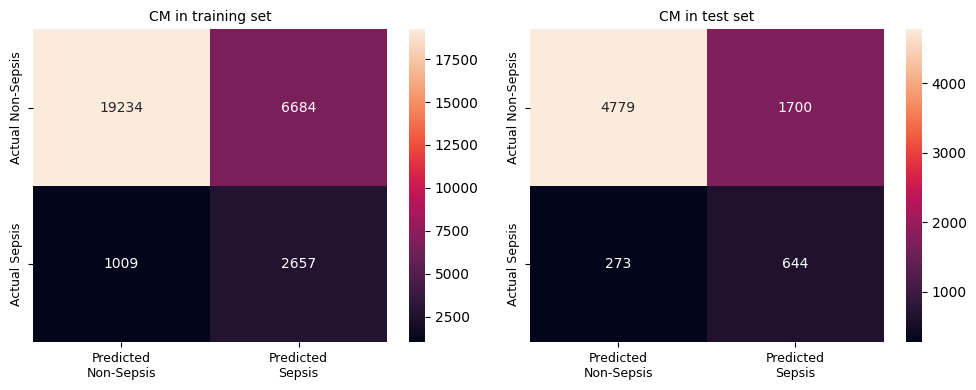

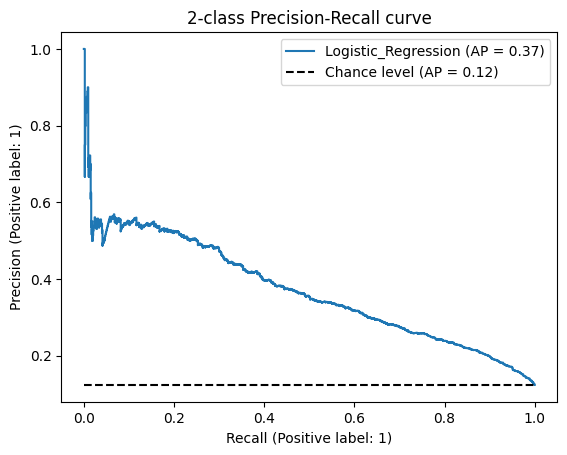

Logistic_Regression AUC : 0.7960


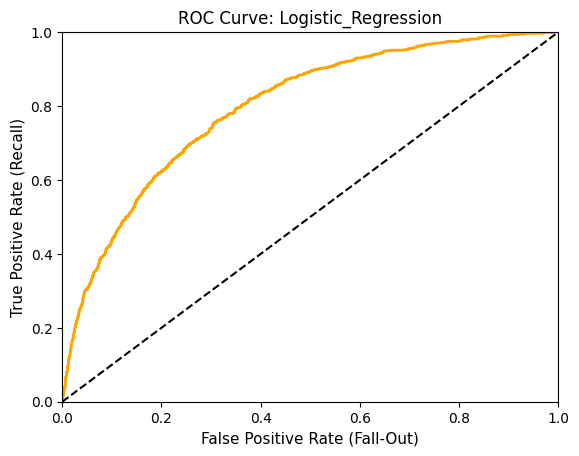

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


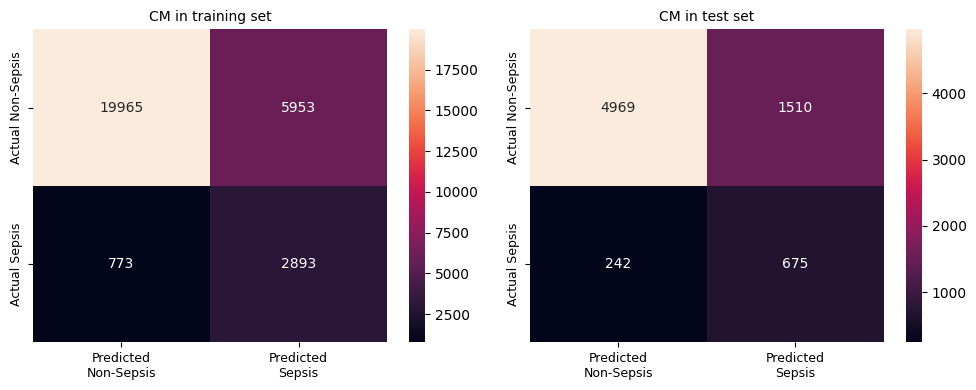

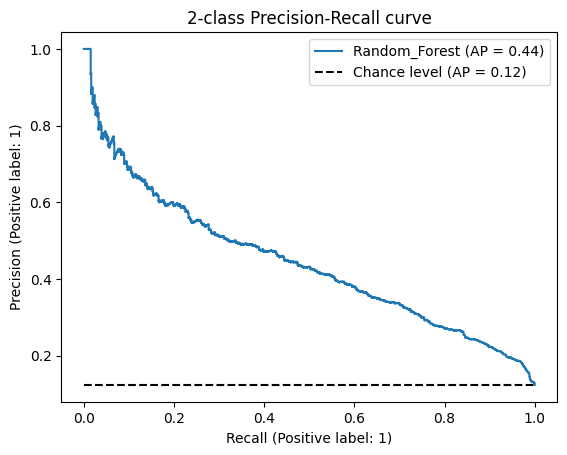

Random_Forest AUC : 0.8332


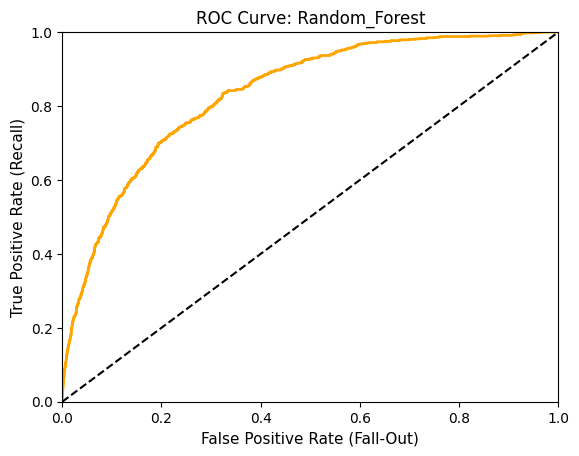

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


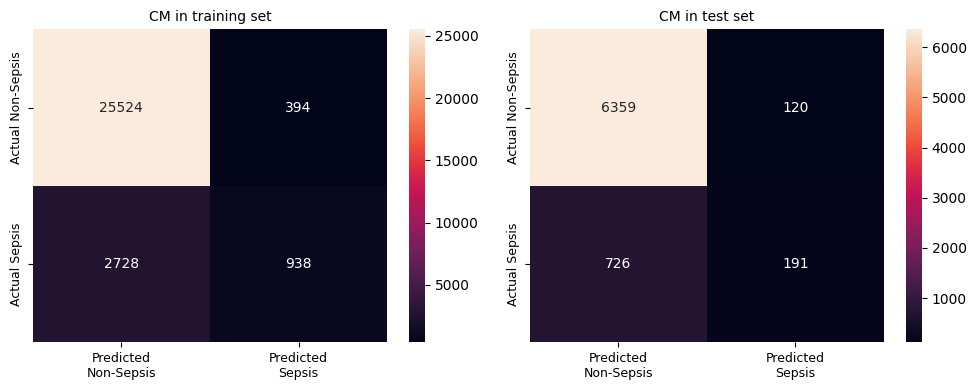

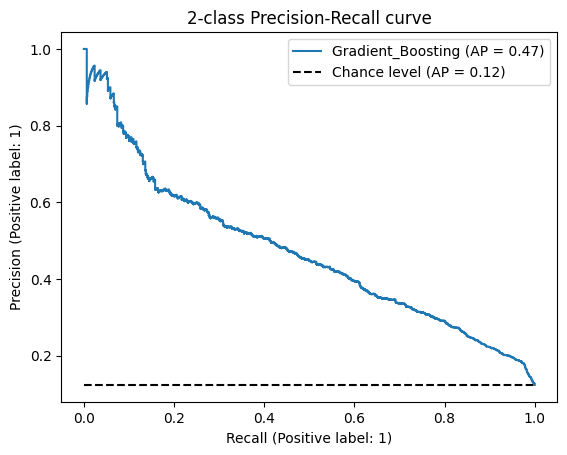

Gradient_Boosting AUC : 0.8391


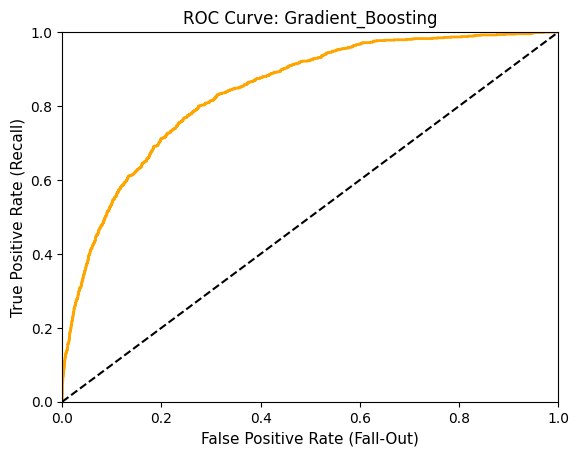

<Figure size 600x600 with 0 Axes>

In [142]:
mp.plot_results(candidate_models, class_weights, X_t3_train, X_t3_test, y_t3_train, y_t3_test)

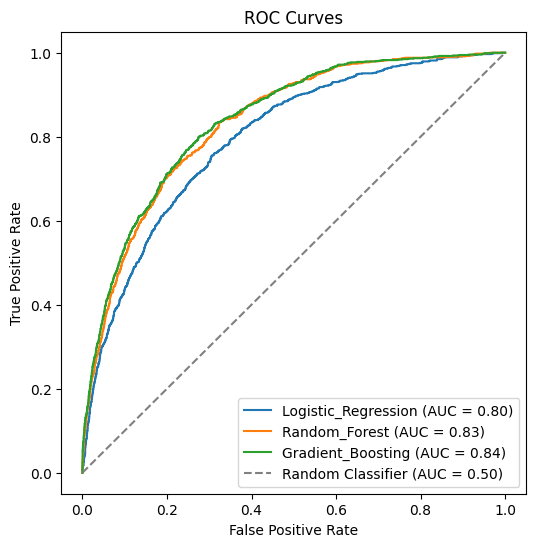

In [143]:
mp.plot_combined_roc_curves(candidate_models, X_t3_test, y_t3_test)

# 7. Feature Importance

In [144]:
candidate_models.keys()

dict_keys(['Logistic_Regression', 'Random_Forest', 'Gradient_Boosting'])

In [145]:
candidate_models.items()

dict_items([('Logistic_Regression', LogisticRegression(C=0.1, class_weight={0: 1.147, 1: 7.8014},
                   max_iter=10000000000, penalty=None, random_state=901)), ('Random_Forest', RandomForestClassifier(class_weight={0: 1.147, 1: 7.8014}, max_depth=7,
                       min_samples_leaf=25, min_samples_split=250,
                       random_state=901)), ('Gradient_Boosting', GradientBoostingClassifier(random_state=901))])

In [146]:
candidate_models['Logistic_Regression']

LogisticRegression(C=0.1, class_weight={0: 1.147, 1: 7.8014},
                   max_iter=10000000000, penalty=None, random_state=901)

### 7.1 SHAP

In [147]:
target_column = ["IS_SEPSIS"]
feature_columns = dfs_dict_without_missing['top40']['t3'].columns.drop("IS_SEPSIS").tolist()

# Convert 'ITEMID_' column to title
itemid_columns = [col for col in feature_columns if col.startswith('ITEMID_')]
title_mapping = dataLoader.convert_itemid_to_title(itemid_columns, df_desc_labitems)
for itemid, title in title_mapping.items():
    feature_columns[feature_columns.index(itemid)] = title

In [148]:
# Convert numpy array back to DataFrame
X_t3_train_df = pd.DataFrame(X_t3_train, columns=feature_columns)
y_t3_train_df = pd.DataFrame(y_t3_train, columns=target_column)

X_t3_test_df = pd.DataFrame(X_t3_test, columns=feature_columns)
y_t3_test_df = pd.DataFrame(y_t3_test, columns=target_column)

In [149]:
X_t3_train_df

,AGE,GENDER_NUM,Calculated Total CO2 (50804),Glucose (50809),Lactate (50813),pCO2 (50818),pH (50820),pO2 (50821),Alanine Aminotransferase (ALT) (50861),Albumin (50862),...,MCV (51250),Neutrophils (51256),Platelet Count (51265),PT (51274),PTT (51275),RDW (51277),Red Blood Cells (51279),White Blood Cells (51301),RBC (51493),SOFA
0,0.778192,-0.894522,1.752414,-0.462716,1.183096,1.740051,1.667302,1.620154,0.768002,1.424446,...,0.119757,0.542545,0.822458,0.491288,0.498216,0.101746,0.047515,0.091583,-0.362664,1.093229
1,0.102688,-0.894522,-0.567027,2.143926,1.182894,-0.566856,1.667076,-0.561834,-0.769669,-0.700484,...,0.048209,0.571554,-1.013275,0.477419,0.765651,0.053442,0.052713,0.018123,-0.362664,-0.917277
2,-2.476508,-0.894522,-0.567027,-0.462716,-0.843350,-0.566856,-0.599789,-0.561834,0.753203,1.432088,...,0.105447,0.561811,0.622922,-2.079768,-1.965680,0.054713,0.077600,0.171165,-0.362664,1.087221
3,-1.739595,1.117915,1.725100,1.993330,1.223613,1.731119,1.666243,1.831941,1.052154,1.424234,...,-15.520688,0.442896,-0.953414,0.512974,0.693824,-12.811911,-15.734265,-0.067581,-0.362664,1.097234
4,0.532554,1.117915,-0.567027,-0.462716,-0.843350,-0.566856,-0.599789,-0.561834,0.753203,-0.700484,...,0.176996,0.571997,-0.507783,0.473385,0.488639,0.059798,0.066417,-0.000242,-0.362664,1.089224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29579,1.453696,1.117915,1.822976,-0.462716,1.183502,1.858412,1.667302,1.561864,-0.769669,-0.700484,...,0.048209,0.566682,1.560742,-2.079768,-1.965680,0.101746,0.057281,0.179327,2.713297,-0.917277
29580,-0.695635,-0.894522,1.809319,-0.462716,1.183704,1.876277,1.667076,1.952407,-0.769669,-0.700484,...,0.105447,0.574876,-0.587598,-2.079768,-1.965680,0.086492,0.063109,0.034447,-0.362664,-0.917277
29581,0.164098,1.117915,-0.567027,-0.462716,-0.843350,-0.566856,-0.599789,-0.561834,-0.769669,-0.700484,...,0.048209,-1.837969,-0.028896,0.471367,0.489836,0.089034,0.059801,-0.081864,-0.362664,-0.917277
29582,-1.371138,1.117915,1.772900,-0.462716,-0.843350,1.798115,1.667122,1.637641,-0.769669,-0.700484,...,0.005280,0.531473,-0.840344,0.468593,0.492470,0.138609,0.066889,-0.057378,-0.362664,-0.917277


#### 7.3.1 Logistic Regression

##### 7.3.1.1 Global feature importance

In [150]:
explainer_lr = shap.Explainer(candidate_models['Logistic_Regression'], X_t3_train_df)  # Create an explainer for your model
shap_values_lr = explainer_lr(X_t3_test_df)  # Calculate SHAP values for your test data

# set a display version of the data to use for plotting (has string values)
shap_values_lr.display_data = shap.datasets.adult(display=True)[0].values

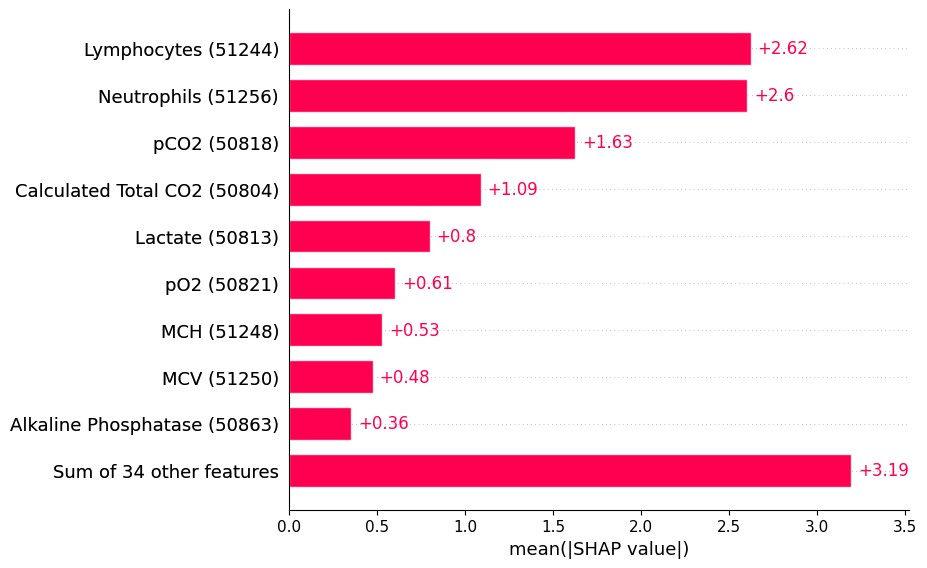

In [151]:
shap.plots.bar(shap_values_lr)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


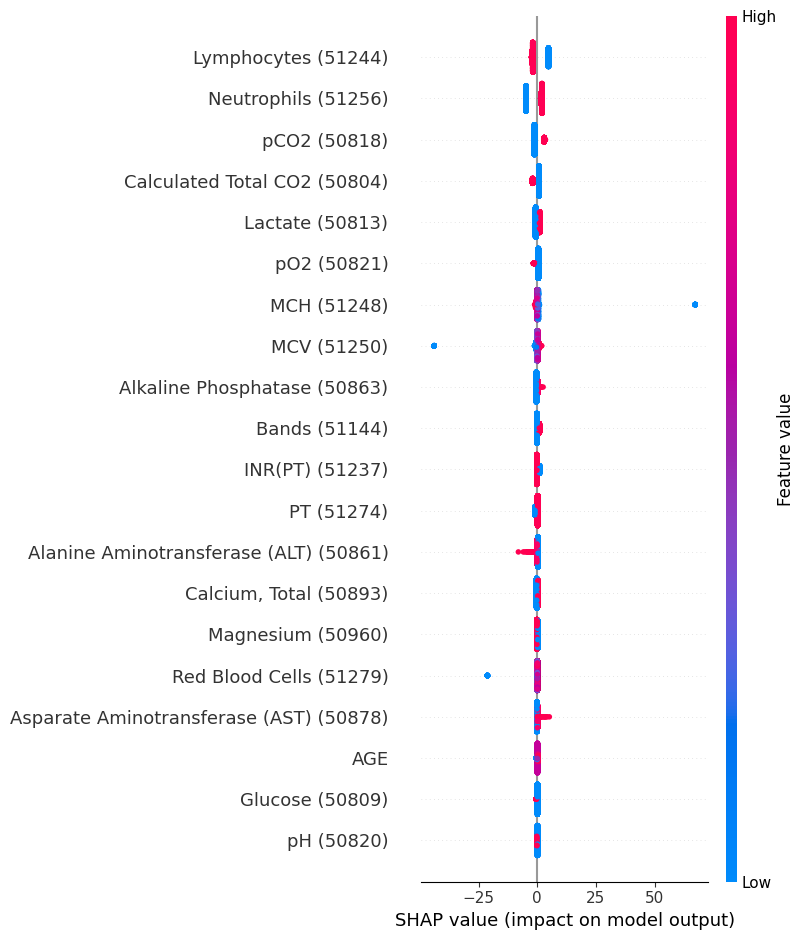

In [152]:
shap.summary_plot(shap_values_lr, X_t3_test_df)

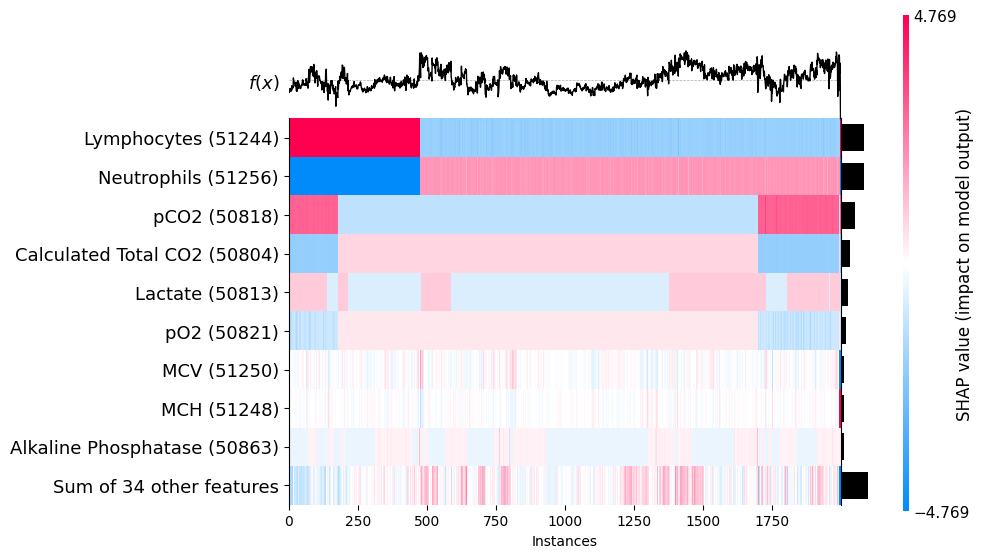

In [153]:
shap.plots.heatmap(shap_values_lr[:2000])

#### 7.3.2 Random Forest

##### 7.3.2.1 Global Feature Importance

In [158]:
explainer_rf = shap.TreeExplainer(candidate_models['Random_Forest'], X_t3_train_df)  # Create an explainer for your model
shap_values_rf = explainer_rf(X_t3_test_df)  # Calculate SHAP values for your test data

# set a display version of the data to use for plotting (has string values)
shap_values_rf.display_data = shap.datasets.adult(display=True)[0].values

 99%|===================| 14710/14792 [02:35<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.426619, while the model output was 0.419824. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
shap.summary_plot(shap_values_rf, X_t3_test_df)

In [ ]:
shap.summary_plot(shap_values_rf[0], X_t3_test_df)

#### 7.3.3 Gradient Boosting

##### 7.3.3.1 Global Feature Importance